=== Starting Validation with bldg_ranges ===
   > Aligning real Bldg=0 vs sim Bldg=0, Var=Cooling:EnergyTransfer [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


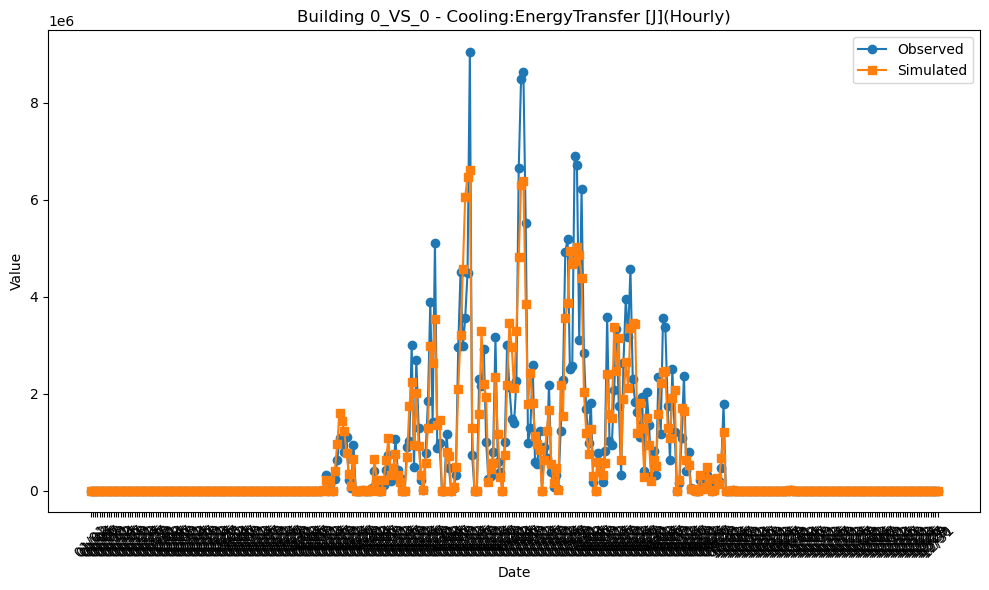

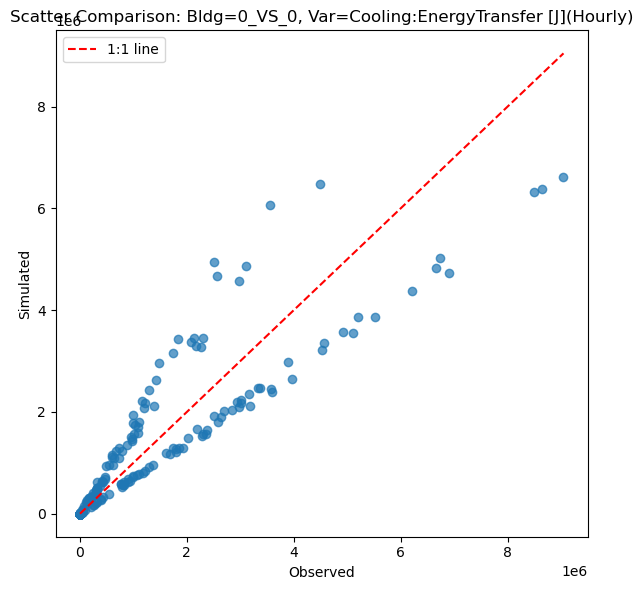

   > Aligning real Bldg=0 vs sim Bldg=0, Var=Electricity:Facility [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


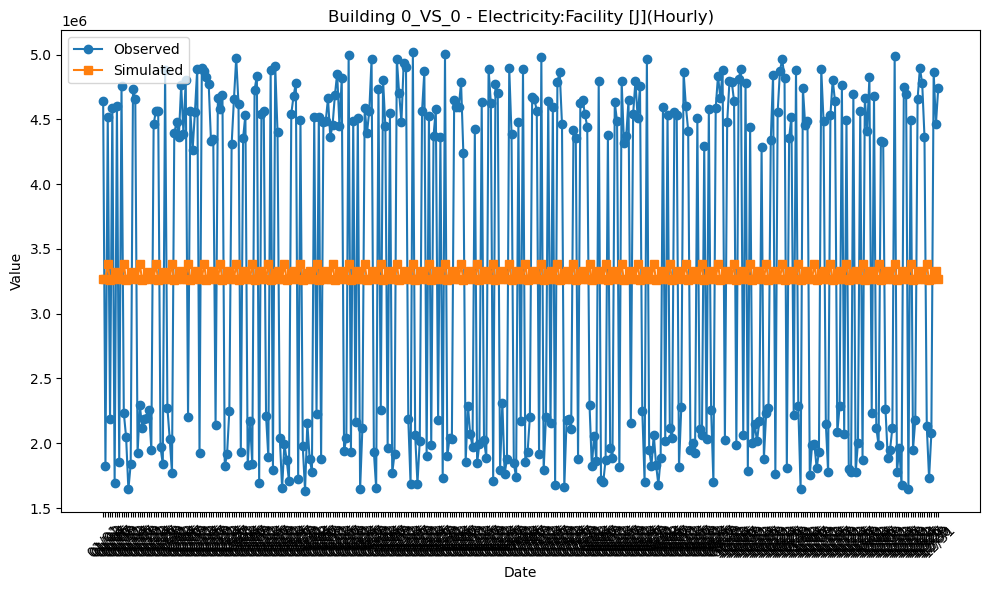

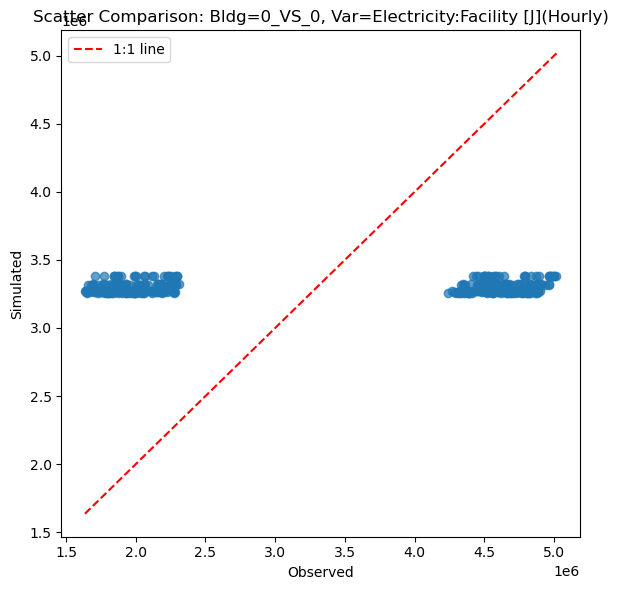

   > Aligning real Bldg=0 vs sim Bldg=0, Var=Heating:EnergyTransfer [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


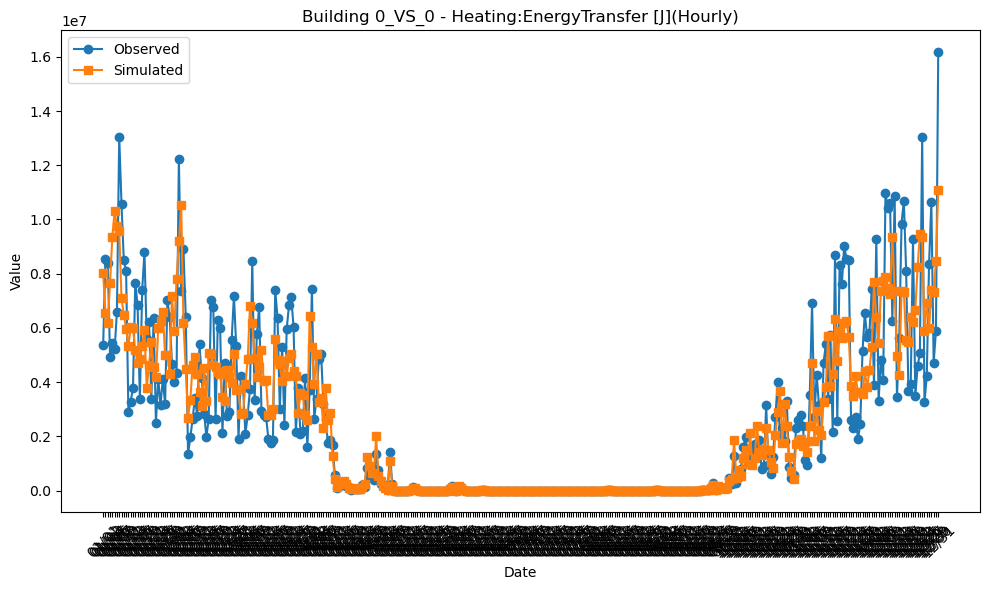

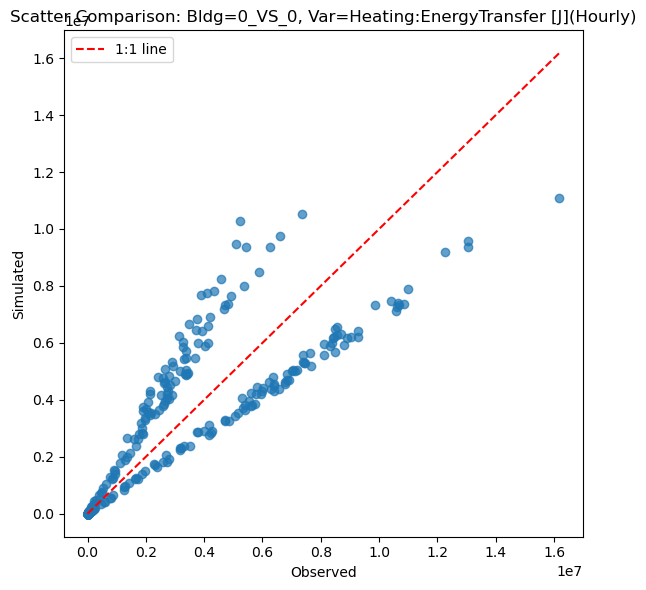

   > Aligning real Bldg=0 vs sim Bldg=0, Var=MYDHW_0_WATERHEATER:Water Heater Heating Energy [J](Daily)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


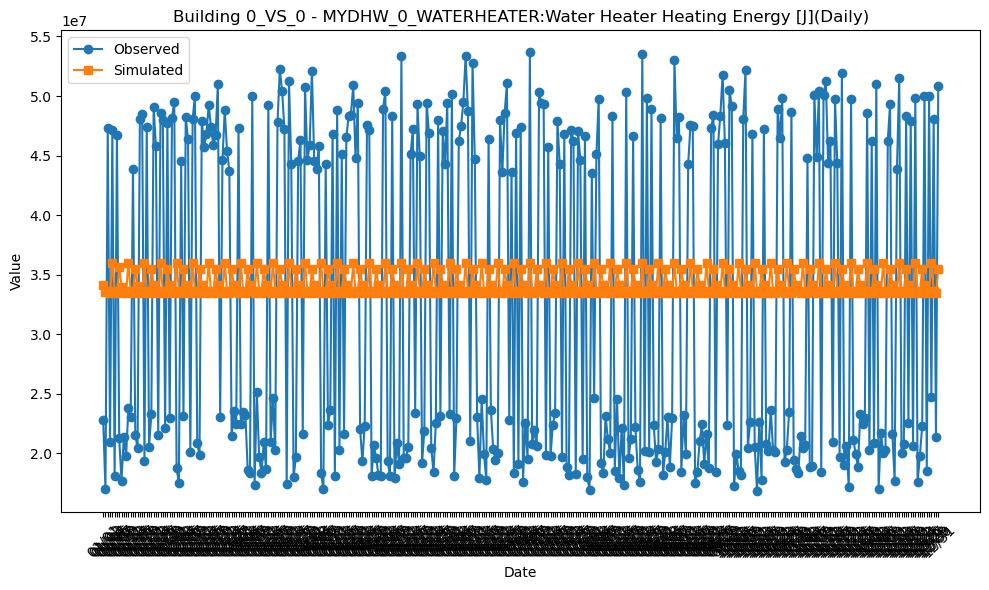

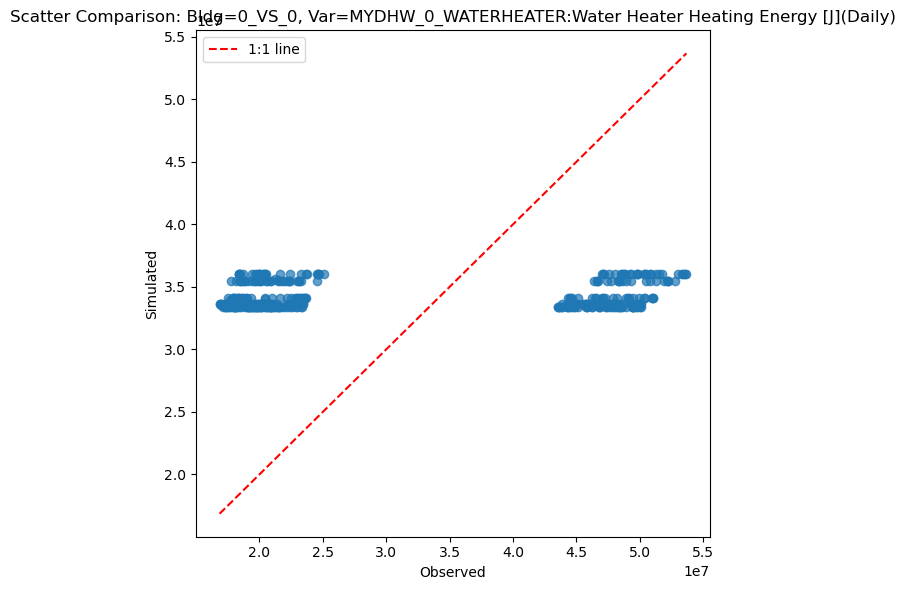

   > Aligning real Bldg=0 vs sim Bldg=1, Var=Cooling:EnergyTransfer [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


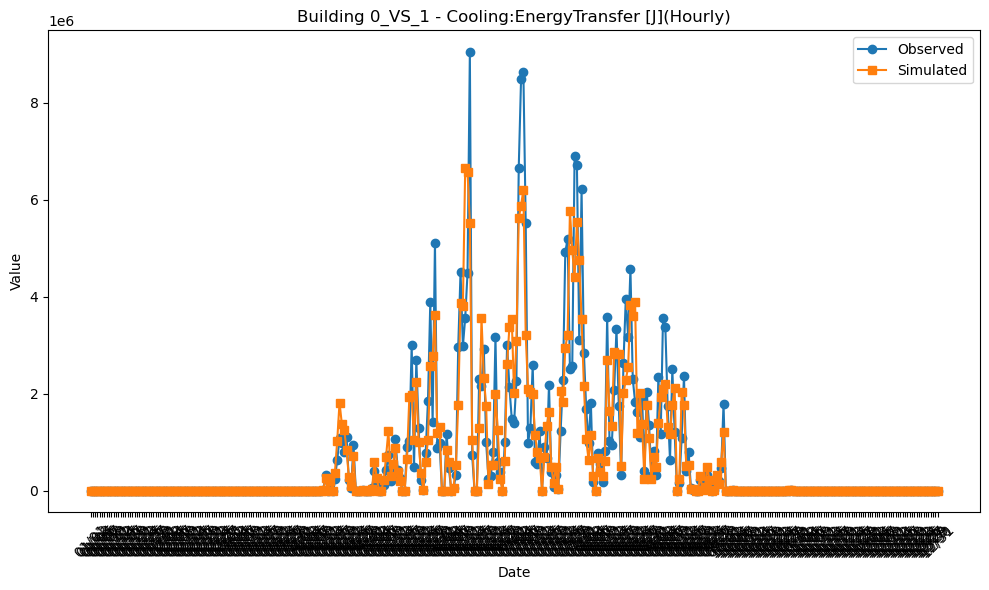

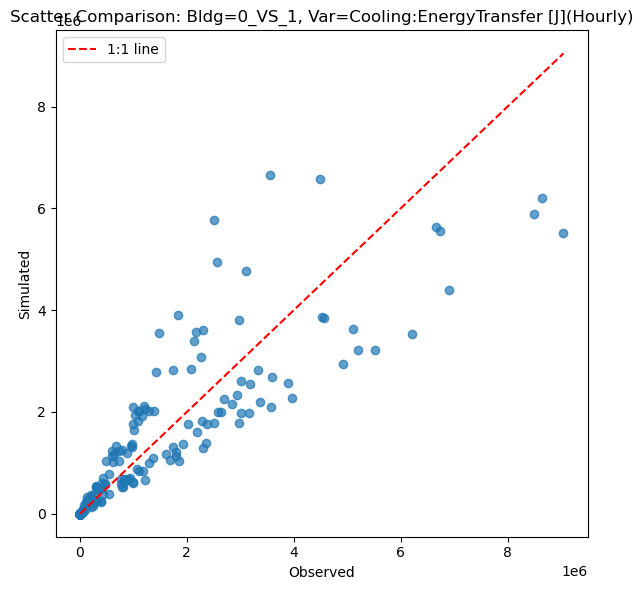

   > Aligning real Bldg=0 vs sim Bldg=1, Var=Electricity:Facility [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


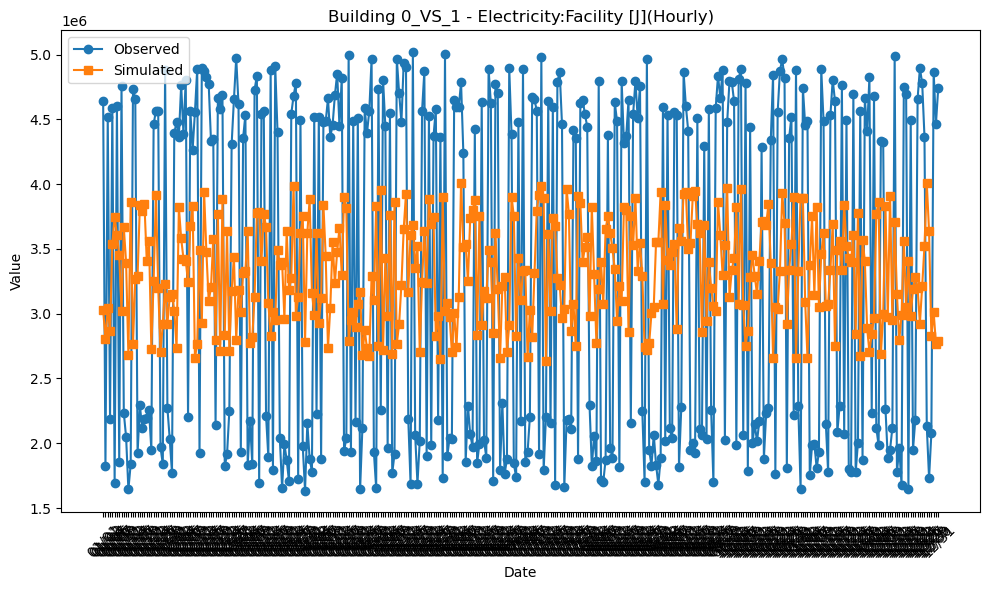

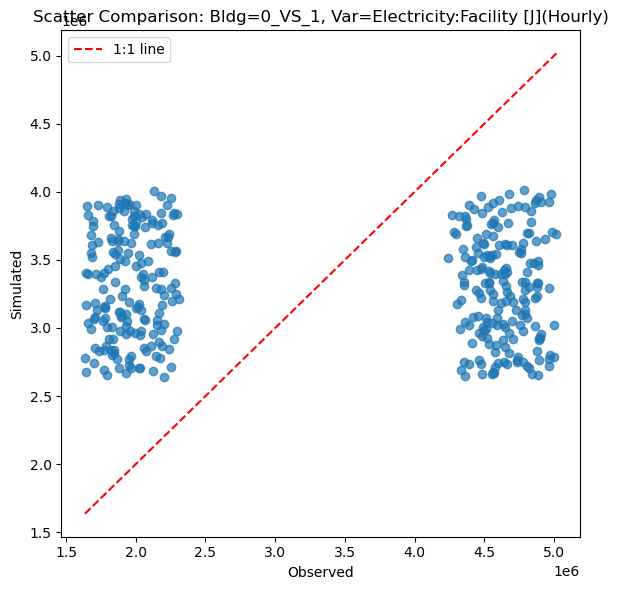

   > Aligning real Bldg=0 vs sim Bldg=1, Var=Heating:EnergyTransfer [J](Hourly)
   > real_sel shape=(1, 367), sim_sel shape=(1, 367)


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [1]:
# main.py

from validation.validate_results_custom import validate_with_ranges
import matplotlib.pyplot as plt
import csv

def main():
    real_data_csv = r"D:\Documents\E_Plus_2030_py\output\results\mock_merged_daily_mean.csv"
    sim_data_csv  = r"D:\Documents\E_Plus_2030_py\output\results\merged_daily_mean_mocked.csv"

    # Example: Compare real building 0 vs. sim buildings [0..4] individually
    bldg_ranges = {
        0: range(0, 5)
        # If you also want real bldg=1 to compare vs. sim bldgs [0..4], do:
        # 1: range(0, 5)
        # etc.
    }

    print("=== Starting Validation with bldg_ranges ===")
    metric_results = validate_with_ranges(
        real_data_path=real_data_csv,
        sim_data_path=sim_data_csv,
        bldg_ranges=bldg_ranges,
        threshold_cv_rmse=30.0
    )

    # ---------------------------------------------------
    # Print summary for each (RealBldg, SimBldg, Variable)
    # ---------------------------------------------------
    print("\n=== Validation Summary ===")
    for (real_bldg, sim_bldg, var_name), mvals in metric_results.items():
        print(f"Real={real_bldg}, Sim={sim_bldg}, Var={var_name} => "
              f"MBE={mvals['MBE']:.2f}, CV(RMSE)={mvals['CVRMSE']:.2f}, "
              f"NMBE={mvals['NMBE']:.2f}, Pass={mvals['Pass']}")

    # ---------------------------------------------------
    # Save metrics to CSV
    #   with columns: RealBldg, SimBldg, VariableName, ...
    # ---------------------------------------------------
    output_csv = "validation_report.csv"
    print(f"\n[INFO] Saving metrics to {output_csv}")
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["RealBldg", "SimBldg", "VariableName", "MBE", "CVRMSE", "NMBE", "Pass"])
        for (real_bldg, sim_bldg, var_name), mvals in metric_results.items():
            writer.writerow([
                real_bldg,
                sim_bldg,
                var_name,
                f"{mvals['MBE']:.2f}",
                f"{mvals['CVRMSE']:.2f}",
                f"{mvals['NMBE']:.2f}",
                mvals['Pass']
            ])

    # ---------------------------------------------------
    # Check for calibration
    #   We trigger calibration if Pass=False
    # ---------------------------------------------------
    print("\n=== Checking for Calibration Needs ===")
    for (real_bldg, sim_bldg, var_name), mvals in metric_results.items():
        if not mvals['Pass']:
            print(f"[CALIBRATION] RealBldg={real_bldg}, SimBldg={sim_bldg}, Var={var_name}: "
                  f"CV(RMSE)={mvals['CVRMSE']:.2f}% > threshold => Trigger calibration steps...")

    # ---------------------------------------------------
    # Bar chart of CV(RMSE) for each (Real, Sim, Var)
    # ---------------------------------------------------
    bar_chart_metrics_for_triple(metric_results, title="CV(RMSE) Validation (Per Real vs. Sim)")

def bar_chart_metrics_for_triple(metric_dict, title="Validation Metrics"):
    """
    Create a bar chart of CV(RMSE) where each bar is (RealBldg vs. SimBldg, VarName).
    """
    if not metric_dict:
        print("[DEBUG] No metrics to plot - metric_dict is empty.")
        return

    labels = []
    cvrmse_values = []
    pass_status = []

    for (real_bldg, sim_bldg, var_name), mvals in metric_dict.items():
        # Example label: "R0-S3-Heating"
        label = f"R{real_bldg}-S{sim_bldg}-{var_name}"
        labels.append(label)
        cvrmse_values.append(mvals['CVRMSE'])
        pass_status.append(mvals['Pass'])

    x = range(len(labels))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(x, cvrmse_values, alpha=0.7)

    # Color-code pass/fail
    for i, bar in enumerate(bars):
        bar.set_color('green' if pass_status[i] else 'red')

    plt.xticks(list(x), labels, rotation=45, ha='right')
    plt.ylabel("CV(RMSE) (%)")
    plt.title(title)
    if cvrmse_values:
        plt.ylim(0, max(cvrmse_values) * 1.1)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


In [1]:
import pandas as pd
import os
import glob
import ast

# Define the folder path
folder_path = r"D:\Documents\E_Plus_2030_py\output\assigned"

# Initialize an empty list to hold DataFrames
df_list = []

# Function to parse range strings into min and max
def parse_range(range_str, param_name, file_name):
    if isinstance(range_str, str):
        try:
            # Safely evaluate the string to a tuple
            range_tuple = ast.literal_eval(range_str)
            if isinstance(range_tuple, (list, tuple)) and len(range_tuple) == 2:
                return range_tuple
            else:
                print(f"Warning: Range for '{param_name}' in '{file_name}' is not a tuple/list of length 2.")
        except (ValueError, SyntaxError):
            print(f"Warning: Unable to parse range '{range_str}' for '{param_name}' in '{file_name}'.")
    else:
        print(f"Warning: 'assigned_value' for '{param_name}' in '{file_name}' is not a string.")
    return (None, None)

# Function to process parameter files with 'ogc_fid', 'param_name', 'assigned_value'
def process_param_file(df, file_name):
    print(f"\nProcessing parameter file: {file_name}")
    
    # Ensure 'ogc_fid', 'param_name', 'assigned_value' exist
    required_cols = {'ogc_fid', 'param_name', 'assigned_value'}
    if not required_cols.issubset(df.columns):
        print(f"Warning: Required columns {required_cols} not found in {file_name}. Skipping this file.")
        return pd.DataFrame()
    
    # Separate range parameters
    range_df = df[df['param_name'].str.endswith('_range')].copy()
    print(f"Found {len(range_df)} range parameter(s) in {file_name}.")
    
    if not range_df.empty:
        range_df['base_param'] = range_df['param_name'].str.replace('_range$', '', regex=True)
        
        # Apply parse_range with additional parameters for debugging
        range_df[['min_value', 'max_value']] = range_df.apply(
            lambda row: pd.Series(parse_range(row['assigned_value'], row['param_name'], file_name)),
            axis=1
        )
        
        # Check for any None values in min_value or max_value
        invalid_ranges = range_df[(range_df['min_value'].isnull()) | (range_df['max_value'].isnull())]
        if not invalid_ranges.empty:
            print(f"Warning: {len(invalid_ranges)} range(s) in '{file_name}' could not be parsed and are set to None.")
        
        range_df = range_df[['ogc_fid', 'base_param', 'min_value', 'max_value']]
    else:
        print(f"No range parameters found in {file_name}.")
        range_df = pd.DataFrame(columns=['ogc_fid', 'base_param', 'min_value', 'max_value'])
    
    # Separate assigned value parameters
    value_df = df[~df['param_name'].str.endswith('_range')].copy()
    print(f"Found {len(value_df)} assigned value parameter(s) in {file_name}.")
    
    value_df = value_df.rename(columns={'param_name': 'base_param', 'assigned_value': 'assigned_value'})
    value_df = value_df[['ogc_fid', 'base_param', 'assigned_value']]
    
    # Merge ranges with assigned values
    merged_df = pd.merge(value_df, range_df, on=['ogc_fid', 'base_param'], how='left')
    merged_df = merged_df.rename(columns={'base_param': 'param_name'})
    
    print(f"Merged data has {len(merged_df)} entry(ies).")
    
    # Rename 'ogc_fid' to 'BuildingID'
    merged_df = merged_df.rename(columns={'ogc_fid': 'BuildingID'})
    
    return merged_df

# Function to process 'assigned_epw_paths.csv'
def process_epw_paths(df, file_name):
    print(f"\nProcessing EPW paths file: {file_name}")
    
    required_cols = {'ogc_fid', 'epw_path'}
    if not required_cols.issubset(df.columns):
        print(f"Warning: Required columns {required_cols} not found in {file_name}. Skipping this file.")
        return pd.DataFrame()
    
    epw_df = df.rename(columns={'epw_path': 'assigned_value', 'ogc_fid': 'BuildingID'})
    epw_df['param_name'] = 'epw_path'
    epw_df['min_value'] = None
    epw_df['max_value'] = None
    
    # Select and reorder columns
    epw_df = epw_df[['BuildingID', 'param_name', 'assigned_value', 'min_value', 'max_value']]
    
    print(f"EPW paths processed for {len(epw_df)} BuildingID(s).")
    
    return epw_df

# Function to process 'assigned_ground_temps.csv'
def process_ground_temps(df, file_name):
    print(f"\nProcessing ground temperatures file: {file_name}")
    
    required_cols = {'month', 'temp_value'}
    if not required_cols.issubset(df.columns):
        print(f"Warning: Required columns {required_cols} not found in {file_name}. Skipping this file.")
        return pd.DataFrame()
    
    ground_temps = df.set_index('month')['temp_value'].to_dict()
    ground_df = pd.DataFrame({
        'BuildingID': ['Global'] * len(ground_temps),
        'param_name': [f"ground_temp_{month.lower()}" for month in ground_temps.keys()],
        'assigned_value': list(ground_temps.values()),
        'min_value': [None] * len(ground_temps),
        'max_value': [None] * len(ground_temps)
    })
    
    print(f"Ground temperatures processed for {len(ground_df)} month(s).")
    
    return ground_df

# Function to process other parameter files without ranges
def process_other_param_files(df, file_name):
    print(f"\nProcessing other parameter file: {file_name}")
    
    required_cols = {'ogc_fid', 'param_name', 'assigned_value'}
    if not required_cols.issubset(df.columns):
        print(f"Warning: Required columns {required_cols} not found in {file_name}. Skipping this file.")
        return pd.DataFrame()
    
    processed_df = df.copy()
    processed_df['min_value'] = None
    processed_df['max_value'] = None
    
    # Rename 'ogc_fid' to 'BuildingID'
    processed_df = processed_df.rename(columns={'ogc_fid': 'BuildingID'})
    
    # Select and reorder columns
    processed_df = processed_df[['BuildingID', 'param_name', 'assigned_value', 'min_value', 'max_value']]
    
    print(f"Other parameters processed for {len(processed_df)} BuildingID(s).")
    
    return processed_df

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Process each CSV file
for file in csv_files:
    file_name = os.path.basename(file)
    
    # Skip files that don't start with "assigned_"
    if not file_name.startswith("assigned_"):
        print(f"\nSkipping unrecognized file: {file_name}")
        continue
    
    # Read the CSV file
    try:
        df = pd.read_csv(file)
        print(f"\nSuccessfully read file: {file_name}")
    except Exception as e:
        print(f"\nError reading {file_name}: {e}")
        continue
    
    # Determine which processing function to use based on file name
    if file_name.startswith("assigned_dhw_params") or \
       file_name.startswith("assigned_fenez_params") or \
       file_name.startswith("assigned_hvac_params") or \
       file_name.startswith("assigned_geometry") or \
       file_name.startswith("assigned_lighting") or \
       file_name.startswith("assigned_setzone_params") or \
       file_name.startswith("assigned_ventilation"):
        # These files have 'ogc_fid', 'param_name', 'assigned_value'
        processed_df = process_param_file(df, file_name)
        if not processed_df.empty:
            df_list.append(processed_df)
    
    elif file_name == "assigned_epw_paths.csv":
        # Special handling for EPW paths
        epw_df = process_epw_paths(df, file_name)
        if not epw_df.empty:
            df_list.append(epw_df)
    
    elif file_name == "assigned_ground_temps.csv":
        # Special handling for ground temperatures
        ground_df = process_ground_temps(df, file_name)
        if not ground_df.empty:
            df_list.append(ground_df)
    
    else:
        # Handle any other files that match the general pattern
        other_df = process_other_param_files(df, file_name)
        if not other_df.empty:
            df_list.append(other_df)

# Combine all DataFrames into a master DataFrame
if df_list:
    master_df = pd.concat(df_list, ignore_index=True)
    print("\nAll files have been successfully processed and combined.")
else:
    master_df = pd.DataFrame(columns=['BuildingID', 'param_name', 'assigned_value', 'min_value', 'max_value'])
    print("\nNo valid data found to combine.")

# Verify all BuildingIDs are present
unique_building_ids = master_df['BuildingID'].unique()
print(f"\nUnique BuildingIDs in master DataFrame: {unique_building_ids}")

# Save the master DataFrame to CSV
output_path = os.path.join(folder_path, "master_parameters.csv")
try:
    master_df.to_csv(output_path, index=False)
    print(f"Master parameter CSV has been created at: {output_path}")
except Exception as e:
    print(f"Error saving master_parameters.csv: {e}")



Successfully read file: assigned_dhw_params.csv

Processing parameter file: assigned_dhw_params.csv

Successfully read file: assigned_fenez_params.csv

Processing parameter file: assigned_fenez_params.csv
Found 276 range parameter(s) in assigned_fenez_params.csv.
Found 546 assigned value parameter(s) in assigned_fenez_params.csv.
Merged data has 546 entry(ies).

Successfully read file: assigned_geometry.csv

Processing parameter file: assigned_geometry.csv
Found 2 range parameter(s) in assigned_geometry.csv.
Found 4 assigned value parameter(s) in assigned_geometry.csv.
Merged data has 4 entry(ies).

Successfully read file: assigned_hvac_building.csv

Processing other parameter file: assigned_hvac_building.csv

Successfully read file: assigned_hvac_zones.csv

Processing other parameter file: assigned_hvac_zones.csv

Successfully read file: assigned_lighting.csv

Processing parameter file: assigned_lighting.csv
Found 0 range parameter(s) in assigned_lighting.csv.
No range parameters fou

D:\Drives\Temp\ipykernel_33660\3749555860.py:198: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(df_list, ignore_index=True)


In [2]:
import os
import glob
import ast
import pandas as pd

# ---------------------
# Folder Path
# ---------------------
FOLDER_PATH = r"D:\Documents\E_Plus_2030_py\output\assigned"

# ---------------------
# Utility: parse_range
# ---------------------
def parse_range(range_str, param_name="", file_name=""):
    """
    Given a string like '(55.0, 65.0)', parse into a tuple (55.0, 65.0).
    If invalid, returns (None, None), and prints a warning.
    """
    if not isinstance(range_str, str):
        print(f"[WARN] 'assigned_value' for '{param_name}' in '{file_name}' is not a string => {range_str}")
        return (None, None)

    try:
        # Safely evaluate the string to a tuple or list
        range_tuple = ast.literal_eval(range_str)
        if isinstance(range_tuple, (list, tuple)) and len(range_tuple) == 2:
            return range_tuple
        else:
            print(f"[WARN] Range for '{param_name}' in '{file_name}' is not a 2-element tuple/list => {range_str}")
    except (ValueError, SyntaxError):
        print(f"[WARN] Unable to parse range '{range_str}' for '{param_name}' in '{file_name}'.")

    return (None, None)


# ---------------------
# process_param_file
# ---------------------
def process_param_file(df, file_name):
    """
    1. Reads DataFrame with columns: ogc_fid, param_name, assigned_value
    2. Splits out rows where param_name ends with '_range'
       to parse the (min, max).
    3. Merges range info with the assigned values to produce columns:
       [BuildingID, param_name, assigned_value, min_value, max_value]
    4. Returns the merged DataFrame (may be empty if something fails).
    """
    print(f"\n[INFO] Processing parameter file: {file_name}")
    
    required_cols = {'ogc_fid', 'param_name', 'assigned_value'}
    if not required_cols.issubset(df.columns):
        print(f"  [WARN] Missing columns {required_cols} in {file_name}. Skipping.")
        return pd.DataFrame()

    # 1) Separate the range parameters: param_name ending with "_range"
    range_mask = df['param_name'].str.endswith('_range', na=False)
    range_df   = df[range_mask].copy()
    value_df   = df[~range_mask].copy()

    print(f"  [DEBUG] Found {len(range_df)} range row(s), {len(value_df)} assigned row(s).")

    # 2) For range_df, rename param_name => base_param, parse assigned_value => (min_value, max_value)
    if not range_df.empty:
        range_df['base_param'] = range_df['param_name'].str.replace('_range$', '', regex=True)
        range_df[['min_value', 'max_value']] = range_df.apply(
            lambda row: pd.Series(parse_range(row['assigned_value'], row['param_name'], file_name)),
            axis=1
        )
        # Keep just the essential columns
        range_df = range_df[['ogc_fid','base_param','min_value','max_value']]
    else:
        # If empty, create an empty DF with the needed columns
        range_df = pd.DataFrame(columns=['ogc_fid','base_param','min_value','max_value'])

    # 3) For value_df, rename param_name => base_param, assigned_value => assigned_value
    value_df = value_df.rename(columns={'param_name':'base_param', 'assigned_value':'assigned_value'})
    value_df = value_df[['ogc_fid','base_param','assigned_value']]

    # 4) Merge them on [ogc_fid, base_param] => (min_value, max_value) attached
    merged_df = pd.merge(value_df, range_df, on=['ogc_fid','base_param'], how='left')
    
    # 5) Rename columns to final
    merged_df = merged_df.rename(columns={'base_param': 'param_name', 'ogc_fid': 'BuildingID'})

    print(f"  [INFO] Merged => {len(merged_df)} row(s) in final output for {file_name}.")
    return merged_df


# ---------------------
# process_epw_paths
# ---------------------
def process_epw_paths(df, file_name):
    """
    For assigned_epw_paths.csv, typical columns: ogc_fid, epw_path
    We unify them to [BuildingID, param_name='epw_path', assigned_value, min_value, max_value].
    """
    print(f"\n[INFO] Processing EPW paths file: {file_name}")
    required_cols = {'ogc_fid', 'epw_path'}
    if not required_cols.issubset(df.columns):
        print(f"  [WARN] Missing {required_cols} in {file_name}. Skipping.")
        return pd.DataFrame()

    df = df.rename(columns={'ogc_fid':'BuildingID', 'epw_path':'assigned_value'})
    df['param_name'] = 'epw_file_path'
    df['min_value']  = None
    df['max_value']  = None

    out_df = df[['BuildingID','param_name','assigned_value','min_value','max_value']].copy()
    print(f"  [INFO] Processed {len(out_df)} row(s) from {file_name}.")
    return out_df


# ---------------------
# process_ground_temps
# ---------------------
def process_ground_temps(df, file_name):
    """
    For assigned_ground_temps.csv, typical columns: month, temp_value
    We'll produce rows with BuildingID='Global' or 'ALL', param_name='ground_temp_<month>',
    assigned_value=<temp_value>, min_value=None, max_value=None
    """
    print(f"\n[INFO] Processing ground temperatures file: {file_name}")
    required_cols = {'month', 'temp_value'}
    if not required_cols.issubset(df.columns):
        print(f"  [WARN] Missing {required_cols} in {file_name}. Skipping.")
        return pd.DataFrame()

    out_data = []
    for idx, row in df.iterrows():
        month_name = str(row['month']).strip()
        val = row['temp_value']
        param_name = f"ground_temp_{month_name}"
        out_data.append(['Global', param_name, val, None, None])

    out_df = pd.DataFrame(out_data, columns=[
        'BuildingID','param_name','assigned_value','min_value','max_value'
    ])
    print(f"  [INFO] Created {len(out_df)} ground-temp row(s) from {file_name}.")
    return out_df


# ---------------------
# read_and_merge_assigned_files
# ---------------------
def read_and_merge_assigned_files(folder_path):
    """
    1. Loops over all CSV in folder_path that start with "assigned_"
    2. Decides how to process each file based on file name
    3. Accumulates DataFrames into df_list
    4. Merges them into one final master_df
    """
    all_csv = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []

    for csv_file in all_csv:
        file_name = os.path.basename(csv_file)
        if not file_name.startswith("assigned_"):
            print(f"[SKIP] Not an assigned_ file => {file_name}")
            continue

        print(f"[INFO] Reading: {file_name}")
        try:
            df = pd.read_csv(csv_file)
        except Exception as e:
            print(f"  [ERR] Could not read {file_name} => {e}")
            continue

        # Decide which function to call
        if file_name == "assigned_epw_paths.csv":
            # Special
            out_df = process_epw_paths(df, file_name)

        elif file_name == "assigned_ground_temps.csv":
            # Special
            out_df = process_ground_temps(df, file_name)

        else:
            # Assume param_file
            out_df = process_param_file(df, file_name)

        if not out_df.empty:
            df_list.append(out_df)

    # Combine everything
    if df_list:
        master_df = pd.concat(df_list, ignore_index=True)
        master_df.drop_duplicates(subset=["BuildingID","param_name","assigned_value"], inplace=True)
        master_df.reset_index(drop=True, inplace=True)
        return master_df
    else:
        print("[WARN] No data found in assigned CSVs.")
        return pd.DataFrame(columns=["BuildingID","param_name","assigned_value","min_value","max_value"])


# ---------------------
# Main / Usage
# ---------------------
if __name__ == "__main__":
    master_df = read_and_merge_assigned_files(FOLDER_PATH)

    # Show summary
    print("\n=== MASTER DATAFRAME PREVIEW ===")
    print(master_df.head(50))

    print(f"\n[INFO] total rows in master_df = {len(master_df)}")
    unique_bldg = master_df['BuildingID'].unique()
    print("[INFO] Unique BuildingIDs:", unique_bldg)

    # Save to CSV
    output_csv = os.path.join(FOLDER_PATH, "master_parameters.csv")
    master_df.to_csv(output_csv, index=False)
    print(f"\n[INFO] Saved combined parameters => {output_csv}")


[SKIP] Not an assigned_ file => all_params_long.csv
[INFO] Reading: assigned_dhw_params.csv

[INFO] Processing parameter file: assigned_dhw_params.csv
  [DEBUG] Found 22 range row(s), 22 assigned row(s).
  [INFO] Merged => 22 row(s) in final output for assigned_dhw_params.csv.
[INFO] Reading: assigned_epw_paths.csv

[INFO] Processing EPW paths file: assigned_epw_paths.csv
  [INFO] Processed 2 row(s) from assigned_epw_paths.csv.
[INFO] Reading: assigned_fenez_params.csv

[INFO] Processing parameter file: assigned_fenez_params.csv
  [DEBUG] Found 0 range row(s), 448 assigned row(s).
  [INFO] Merged => 448 row(s) in final output for assigned_fenez_params.csv.
[INFO] Reading: assigned_geometry.csv

[INFO] Processing parameter file: assigned_geometry.csv
  [DEBUG] Found 2 range row(s), 4 assigned row(s).
  [INFO] Merged => 4 row(s) in final output for assigned_geometry.csv.
[INFO] Reading: assigned_ground_temps.csv

[INFO] Processing ground temperatures file: assigned_ground_temps.csv
  [IN

D:\Drives\Temp\ipykernel_34780\2409482645.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  master_df = pd.concat(df_list, ignore_index=True)
